In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy import stats

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics



# Parsing

In [18]:
# парсинг ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [19]:
# преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True).dt.strftime('%d.%m.%Y')

# перенаименование столбцов
df.columns = ['date', 'key_rate']
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [20]:
# общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2621 entries, 0 to 2620
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2621 non-null   datetime64[ns]
 1   key_rate  2621 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.1 KB


In [21]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2621.000000
mean,8.669115
std,3.137033
min,4.250000
25%,7.000000
50%,7.750000
75%,10.500000
max,20.000000


In [22]:
df[:5]

,date,key_rate
0,2024-03-15,16.0
1,2024-03-14,16.0
2,2024-03-13,16.0
3,2024-03-12,16.0
4,2024-03-11,16.0


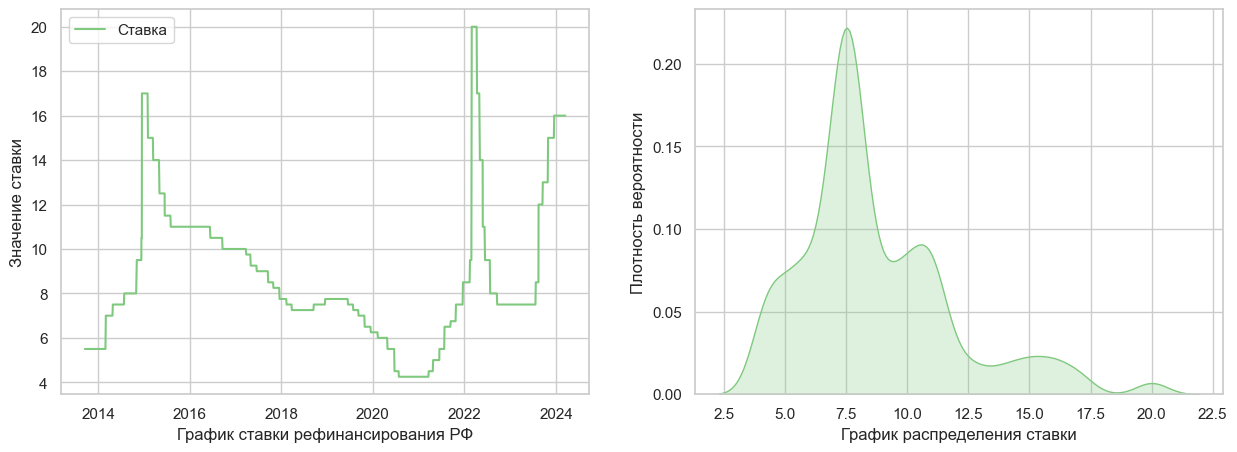

In [23]:
# рисуем график курса ключевой ствки ЦБ РФ и график распределения
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [24]:
# проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9036547541618347, pvalue=8.042869684543905e-38)
Распределение не нормальное


In [25]:
def create_features(data, col_datetime):
    """Создание сезонов и дней недели"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

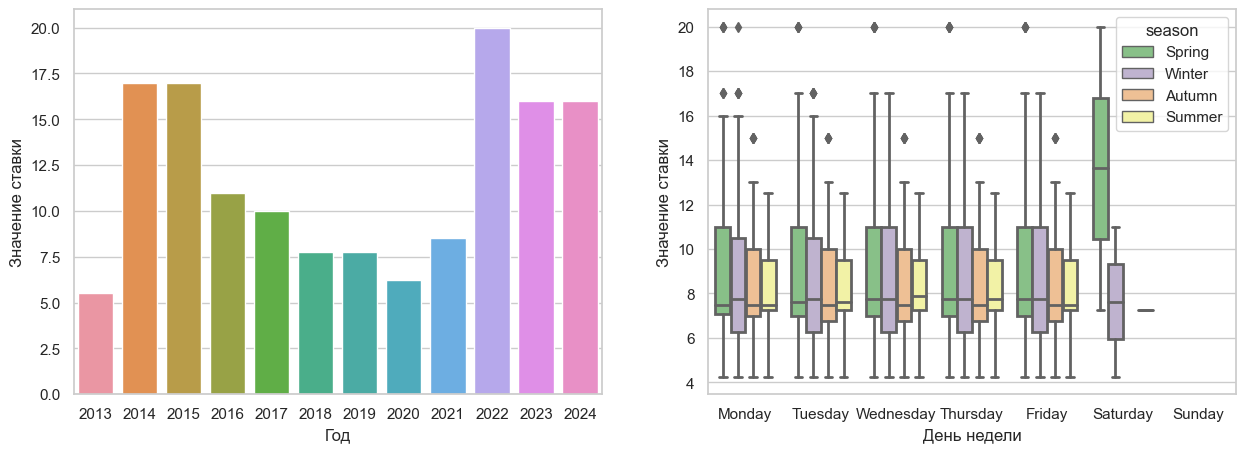

In [26]:
# рисуем графики для анализа
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=axes[0])
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=axes[1], linewidth=2)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Значение ставки')

plt.show()



In [27]:
# дропаем редкие субботние ключевые ставки
#drop_trash = df_features[(df_features.weekday == 'Saturday') | (df_features.weekday == 'Sunday')].index
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

In [28]:
# перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# вычисляем в int, 10% от датасета для его будущего разделения
fix_percent = int(df.shape[0]*0.1)


In [29]:
# сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [30]:
# разделение данных на train, test
df_train = df[:-fix_percent]
df_test = df[-fix_percent:]


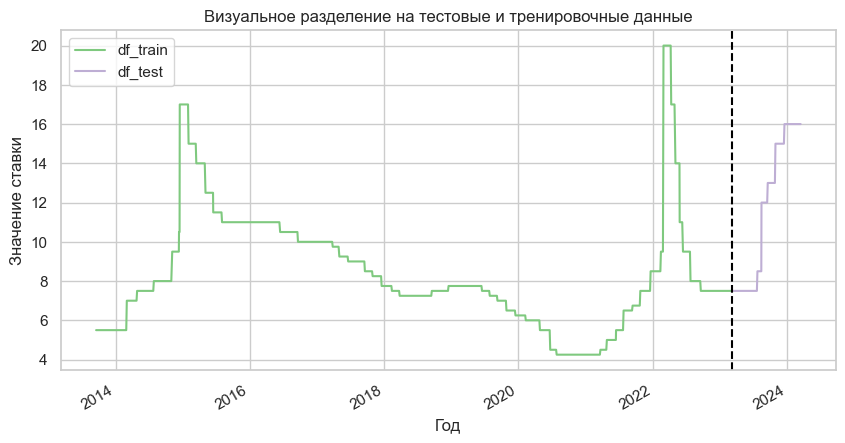

In [31]:
#отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [32]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)
